In [1]:
!pip -q install lxml

In [2]:
# Version 67
# From https://ungoogled-software.github.io/ungoogled-chromium-binaries/releases/linux_portable/64bit/
!wget -q https://github.com/Eloston/ungoogled-chromium-binaries/releases/download/67.0.3396.87-2/ungoogled-chromium_67.0.3396.87-2_linux.tar.xz
!tar -xf ungoogled-chromium_67.0.3396.87-2_linux.tar.xz

# From https://chromedriver.storage.googleapis.com/index.html
!wget -q https://chromedriver.storage.googleapis.com/2.41/chromedriver_linux64.zip
!unzip -o chromedriver_linux64.zip -d ./ungoogled-chromium_67.0.3396.87-1_linux

Archive:  chromedriver_linux64.zip
  inflating: ./ungoogled-chromium_67.0.3396.87-1_linux/chromedriver  


In [3]:
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time
import re
import os
from lxml import etree
import pandas as pd
import numpy as np

'''
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--incognito')
chrome_options.add_argument('log-level=3')
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--no-sandbox")
chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
chrome_options.add_argument("--width=2560")
chrome_options.add_argument("--height=1440")
browser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
'''

'\nchrome_options = webdriver.ChromeOptions()\nchrome_options.add_argument(\'--headless\')\nchrome_options.add_argument(\'--disable-gpu\')\nchrome_options.add_argument(\'--incognito\')\nchrome_options.add_argument(\'log-level=3\')\nchrome_options.add_argument("--disable-dev-shm-usage")\nchrome_options.add_argument("--no-sandbox")\nchrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"\nchrome_options.add_argument("--width=2560")\nchrome_options.add_argument("--height=1440")\nbrowser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)\n'

In [55]:
class recommendation_panel(object):
    """An expectation for checking that the search tag has a minimum number in the document.
    locator - used to find the element
    min_recommendations - Minimum number of tags that should be found
    returns the WebElement once it has the minimum of tags
    """
    def __init__(self, locator, min_recommendations):
        self.locator = locator
        self.minrecmd = min_recommendations

    def __call__(self, driver):
        elements = driver.find_elements(*self.locator)   # Finding the referenced element
        if len(elements) >= self.minrecmd:
            return elements
        else:
            return False

class youtube(object):
    # init variables
    driver = None
    source = None
    element = None
    minrecmd = None
    
    def __init__(self,min_recommendations = 5):
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-gpu')
        chrome_options.add_argument('--incognito')
        chrome_options.add_argument('log-level=3')
        chrome_options.add_argument("--disable-dev-shm-usage")
        chrome_options.add_argument("--no-sandbox")
        chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
        self.driver = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
        self.minrecmd = min_recommendations
        
    def fetch(self, id):
        # Ask browser to go to url
        #self.driver.execute_script("window.open('');")
        #self.driver.switch_to.window(self.driver.window_handles[1])
        self.driver.set_window_position(0, 0)
        self.driver.set_window_size(1968, 1000)
        self.driver.get(f'https://www.youtube.com/watch?v={id}')
        #self.driver.switch_to.window(driver.window_handles[1])
        # Wait until we have the recommendation panel
        self.element = WebDriverWait(self.driver, 10).until(
            recommendation_panel((By.CSS_SELECTOR, 'span#video-title'),self.minrecmd))
        self.source = self.driver.page_source
        #self.getscreenshot()
        #self.driver.close()
        #self.driver.switch_to.window(self.driver.window_handles[0])
        return self.element is not None
    
    def getsource(self):
        if self.source:
            return self.source
        else:
            return 'Empty buffer'#self.driver.page_source
    
    def getscreenshot(self):
        self.driver.save_screenshot('test.png')
        return 'Done'
  
    def getrecommend(self):
        html = etree.HTML(self.source)
        vid = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
        title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
        channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
        views = [x.getchildren()[0].text.replace(' views','') for x in html.findall(".//div[@id='metadata-line']")]
        created = [x.getchildren()[1].text for x in html.findall(".//div[@id='metadata-line']")]
        result = pd.DataFrame(zip(vid,title,channel,views,created),columns=['ID','TITLE','CHANNEL','VIEWS','CREATED'])
        return result
    
    def transcript(self,id='c-7YqBrtuNQ'):
        resp = requests.get(f'https://hierogly.ph/api/transcribe?v={id}',headers={'User-Agent':'Mozilla/5.0'})
        result = re.sub(r'\[[a-zA-Z0-9,.:\s]*\]','',resp.json()['text'])
        return result


In [56]:
yt = youtube(1)

In [57]:
yt.fetch('4Zg18CHaRzY')

True

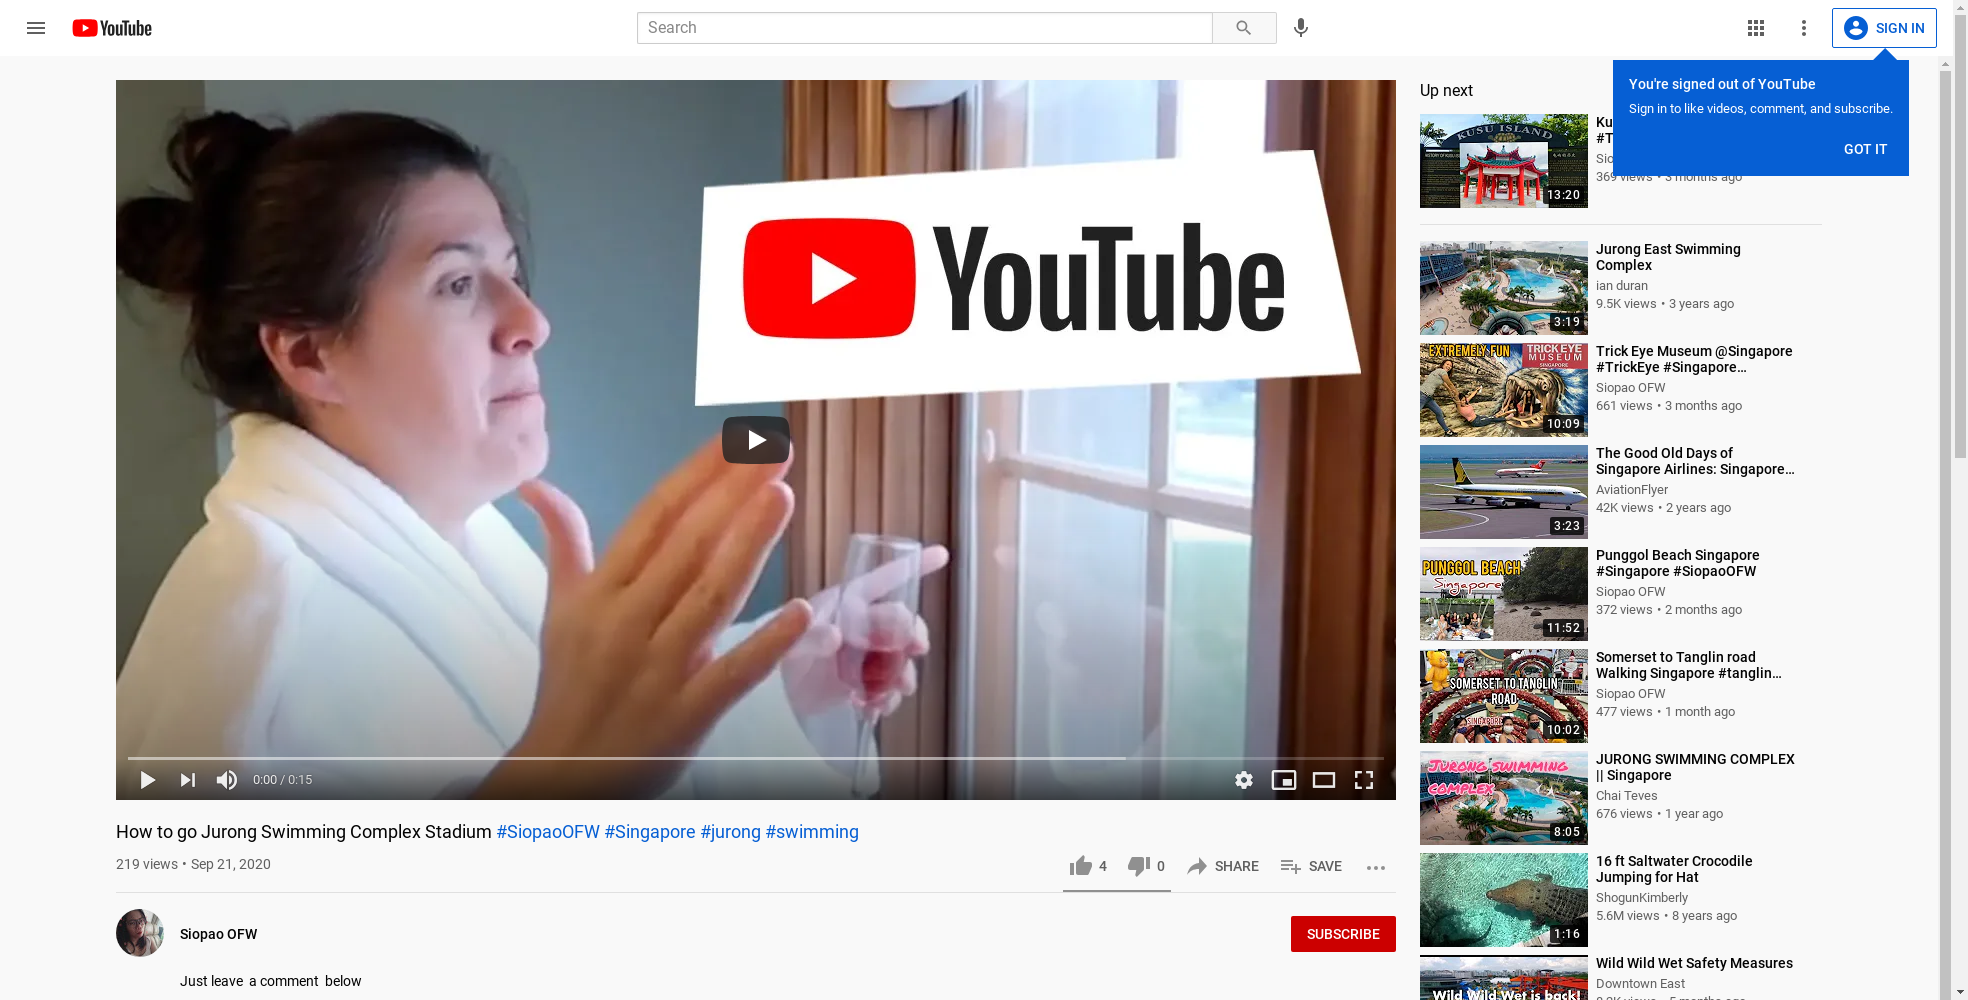

In [58]:
from IPython.display import Image, HTML
yt.getscreenshot()
Image('test.png')

In [59]:
yt.getrecommend()

,ID,TITLE,CHANNEL,VIEWS,CREATED
0,x0oyidvwSsg,Kusu Island Singapore #quick #TOUR #SiopaoOFW...,Siopao OFW,369,3 months ago
1,jnQG96MCoH0,Jurong East Swimming Complex,ian duran,9.5K,3 years ago
2,aQHfT98IsMA,Trick Eye Museum @Singapore #TrickEye #Singap...,Siopao OFW,661,3 months ago
3,sxWCL18FsDQ,The Good Old Days of Singapore Airlines: Singa...,AviationFlyer,42K,2 years ago
4,DXc-XCxX3Mk,Punggol Beach Singapore #Singapore #SiopaoOFW,Siopao OFW,372,2 months ago
5,RRr5dgAmQO4,Somerset to Tanglin road Walking Singapore #ta...,Siopao OFW,477,1 month ago
6,YeJoBmYHCGI,JURONG SWIMMING COMPLEX || Singapore,Chai Teves,676,1 year ago
7,YelppVmdXxY,16 ft Saltwater Crocodile Jumping for Hat,ShogunKimberly,5.6M,8 years ago
8,d_e6iMal17c,Wild Wild Wet Safety Measures,Downtown East,8.2K,5 months ago


In [62]:
yt.transcript('x0oyidvwSsg')

". All the choices meet me at the cornerstone. I know that i can't be without you. This bond is solid gold, we're a diamond in an ammo. It took me forever to find you will be there to guide you in every way, calling  as we wait for the smoke to clear and we watch our dreams together, we can touch the stars. I know that we will see december will be there to guide you in every way is , hello, , , , uh, , , , , ta-da, ,  , , , so , , , , , , hey , foreign, it's the calm before the storms did you think? Can you hear me me, wherever, with the ground beneath your feet, it's the calm before the storm things hey wherever with a whisper , one two: three , , , , , , foreign , , so , , bye, good times, , um, yay, all right, , bye, "

In [11]:
html = etree.HTML(yt.driver.page_source)

In [12]:
## Get the IDs from all the anchors
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]

['WmkZRqvM1Mk',
 'XmtXC_n6X6Q',
 '7OMxBlK46wY',
 '3G1EyvRZmOs',
 'mFP_AjJeP-M',
 'CmtH3nIlELc',
 'xi6r3hZe5Tg',
 'fq70UHD8DrM',
 'k3QiW0gEpYM',
 'xiyldB2eCJY',
 'Iu6_fJEW8y8',
 'quLhkqwtOg8',
 'llh52RktRxU',
 'd2CoZQcRJ14',
 'CsR2Xy-HGPk',
 'g-xsCsQQxiw',
 '4Wrc4fHSCpw',
 'bOOXmfkXpkM',
 'NOEBVWc8crI',
 'AHORSwsRIEM']

In [13]:
# Recommended Video Channels
[x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]

['CNA Insider',
 'Netflix',
 'National Geographic',
 'The University of Melbourne',
 'Real Science',
 'Free High-Quality Documentaries',
 'National Geographic',
 'touropia',
 'Timeline - World History Documentaries',
 'Spark',
 'CNA Insider',
 'National Geographic Asia',
 'National Geographic',
 'CNA',
 "Rick Steves' Europe",
 'CNA',
 'Veritasium',
 'Bushradical',
 'Timeline - World History Documentaries',
 'HISTORY']

In [14]:
# Recommended Video IDs
[str.split(x.attrib['href'],'=')[1] for x in html.findall(".//span[@id='video-title']/../..")]

['WmkZRqvM1Mk',
 'XmtXC_n6X6Q',
 '7OMxBlK46wY',
 '3G1EyvRZmOs',
 'mFP_AjJeP-M',
 'CmtH3nIlELc',
 'xi6r3hZe5Tg',
 'fq70UHD8DrM',
 'k3QiW0gEpYM',
 'xiyldB2eCJY',
 'Iu6_fJEW8y8',
 'quLhkqwtOg8',
 'llh52RktRxU',
 'd2CoZQcRJ14',
 'CsR2Xy-HGPk',
 'g-xsCsQQxiw',
 '4Wrc4fHSCpw',
 'bOOXmfkXpkM',
 'NOEBVWc8crI',
 'AHORSwsRIEM']

In [15]:
# Recommended Video Titles
[x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]

["A new home for Asia's largest bird park | The Great Migration | Full Episode",
 'Our Planet | From Deserts to Grasslands | FULL EPISODE | Netflix',
 "Yellowstone (Full Episode) | America's National Parks",
 'When China Rules the World',
 'The Insane Biology of: The Octopus',
 'Cocos Island - The mysterious island in the Pacific - FULL VERSION!!',
 'City of the Future: Singapore – Full Episode | National Geographic',
 '25 Most Amazing Ancient Ruins of the World',
 'Why Did The Egyptians Stop Building Pyramids? | Immortal Egypt | Timeline',
 "Stuck In An Airport Without Any Money | The World's Best Airport: Changi | Spark",
 'Inside The Singapore Zoo During COVID-19 Lockdown | On The Red Dot | Inside A Zoo | Part 1/4',
 'Secrets Of The Great Wall | Ancient China From Above | National Geographic',
 'Inside Terminal 4: Terminal of Tomorrow – Full Episode | National Geographic',
 "What does it take to maintain Singapore's Jewel Changi Airport? | Jewel After Hours | Full Episode",
 "Scotla

In [41]:
# Get Popularity views
[x.getchildren()[0].text.replace(' views','') for x in html.findall(".//div[@id='metadata-line']")]
# df['Val'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

['392K',
 '8.1M',
 '1.2M',
 '1.2M',
 '3.1M',
 '4.1M',
 '8.1M',
 '3.5M',
 '2M',
 '335K',
 '93K',
 '898K',
 '1.7M',
 '362K',
 '3M',
 '548K',
 '5.4M',
 '2.9M',
 '5.2M',
 '80K']

In [42]:
pd.DataFrame(zip(vid,title,channel,views),columns=['ID','TITLE','CHANNEL','VIEWS'])['VIEWS'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

0      392000
1     8100000
2     1200000
3     1200000
4     3100000
5     4099999
6     8100000
7     3500000
8     2000000
9      335000
10      93000
11     898000
12    1700000
13     362000
14    3000000
15     548000
16    5400000
17    2900000
18    5200000
19      80000
Name: VIEWS, dtype: int64

In [53]:
# Get Created data
[x.getchildren()[1].text for x in html.findall(".//div[@id='metadata-line']")]

['11 months ago',
 '8 months ago',
 '2 weeks ago',
 '8 years ago',
 '1 month ago',
 '1 year ago',
 '2 years ago',
 '9 months ago',
 '2 years ago',
 '2 weeks ago',
 '1 month ago',
 '2 months ago',
 '2 years ago',
 '1 year ago',
 '1 year ago',
 '1 year ago',
 '3 weeks ago',
 '3 weeks ago',
 '2 years ago',
 '1 week ago']

In [54]:
vid = [str.split(x.attrib['href'],'=')[1] for x in html.findall(".//a[@id='thumbnail']") if ('href' in x.attrib.keys())]
title = [x.attrib['title'] for x in html.findall(".//span[@id='video-title']")]
channel = [x.text for x in html.findall(".//div[@id='metadata']/div/ytd-channel-name/div/div/yt-formatted-string")]
views = [x.getchildren()[0].text.replace(' views','') for x in html.findall(".//div[@id='metadata-line']")]
created = [x.getchildren()[1].text for x in html.findall(".//div[@id='metadata-line']")]
pd.DataFrame(zip(vid,title,channel,views,created),columns=['ID','TITLE','CHANNEL','VIEWS','CREATED'])

,ID,TITLE,CHANNEL,VIEWS,CREATED
0,WmkZRqvM1Mk,A new home for Asia's largest bird park | The ...,CNA Insider,392K,11 months ago
1,XmtXC_n6X6Q,Our Planet | From Deserts to Grasslands | FULL...,Netflix,8.1M,8 months ago
2,7OMxBlK46wY,Yellowstone (Full Episode) | America's Nationa...,National Geographic,1.2M,2 weeks ago
3,3G1EyvRZmOs,When China Rules the World,The University of Melbourne,1.2M,8 years ago
4,mFP_AjJeP-M,The Insane Biology of: The Octopus,Real Science,3.1M,1 month ago
5,CmtH3nIlELc,Cocos Island - The mysterious island in the Pa...,Free High-Quality Documentaries,4.1M,1 year ago
6,xi6r3hZe5Tg,City of the Future: Singapore – Full Episode |...,National Geographic,8.1M,2 years ago
7,fq70UHD8DrM,25 Most Amazing Ancient Ruins of the World,touropia,3.5M,9 months ago
8,k3QiW0gEpYM,Why Did The Egyptians Stop Building Pyramids? ...,Timeline - World History Documentaries,2M,2 years ago
9,xiyldB2eCJY,Stuck In An Airport Without Any Money | The Wo...,Spark,335K,2 weeks ago


## BTO Transcripts

In [37]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [139]:
transcript('rb_adz0tkOw')

"Both of us, we plant a lot of strawberries la on each other's lands. What * screams * Hi, I'm Bolin, I'm Qing, I'm Peps Hi, I'm Leah, and this is Zula ChickChats. Okay, hi guys welcome to today's episode of ChickChats. Why Are you all very nervous? Yes, this is my first time on ChickChats Welcome And today's episode we'll be talking about being in the grey area as much requested from the comments section below. Ah So we hear you okay, we will do this episode for you guys. So my first question to you guys, then, is what happened. Okay, whoever wants can share first la What happened. Bolin, Let's start with Bolin. No Qing should start because she's the new person. Why me? Oh my god? Yes, What happened. I met the person through an app Okay, So we hit off like we talk, then after that move to Telegram. But the thing right we went out for so many times right. The places we go to right were like-, not the kind of place that you and your friends would go to. For example, For example, I need 

In [122]:
transcript('5L31Wbrg7tE')

"On one of the days um, we were supposed to have a date .... He came to my house like downstairs. Then I no time to draw eyebrows no time to draw anything right. Then we [ sat ] at the lamp post. There [, I made ] sure to choose the dimmest lamppost Hi. I ’ m Julian Hi. I ’ m Amanda Hi. I ’ m John Hi. I ’ m Leah and this is Zula ChickChats Hi guys welcome to today. ’ s, episode of Zula ChickChats And today we ’ re gon na be talking about- the honeymoon phase in relationships. We have 3 people over here to share uh- their honeymoon phases in their relationships. So…. The first Can you: why Can you explain what the honeymoon phase is I ...? What do you mean You don, ’ t know I ’ m married. I forgot about it. It ’ s been a long time ago. Okay, so the honeymoon phase, I guess, would be the period before your relationship starts getting serious, All the butterflies, all the romantic gestures, Oh ..., For the first question: maybe we ’ ll, let the audience know for you guys. How long have yo

In [140]:
transcript('cYtSEj1v0ew')

"This is John and Jill. They are about to get married and start a family, but first they have to plan for their future and it's not buying the perfect home. Both John and Jill are working polygraph and the earn a combined monthly salary of $ 4,000. Ideally, they would like to live near their parents in the ground, so many options is easy to get confused now. Do you know what options you have, how welcome number option? 1, a 3-bedroom easy in some balance, a 3-bedroom easy and the balance will cost you about. Seven hundred ninety thousand dollars there's a monthly household income of four thousand dollars. You will be able to take a bank loan of up to two hundred and twenty thousand dollars. Next, let's start by it, you can receive a CPF housing grant releases of up to $ 30,000. This review is four hundred ninety thousand dollars, which has to be paid up front and and resupply suspend for thirty. Nine thousand five hundred dollars has to be paid cash, while the rest can be covered by CP

In [145]:
transcript('mPHGGxZwICI')

"My name is I've been working for about two years. My name is Rob. I'Ve been working for about two years, six years, plus I think five years plus I'm very sure, let's see God my location off just nice kata-kata and they realize okay might as well. We just did I just graduated. Yes, I think two years ago yeah - and I guess it just seemed like a natural information from that February. For the column, one poet a key numbers, a thousand by hello, I'm Hansel - I just graduated from in yet last year, and now I'm doing an internship of jewelry come and your student, your tree, we have been together what six? Yes, I think with us always day. Video, what does the you need to be married before you can apply for the blueblack all controller? I mean you're gon na collect the key. Oh boss, you don't need to be married, like yeah, you can apply first, then you get true or false. It is possible to play pain, zero cash yeah. You can actually go share without paying any cash. It wasn't actually, when w